# Diagnosing Bias in Facial Detection Systems
To train our facial detection models, we will use two sets of data: The [positive examples](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (i.e, of faces) and [negative examples](http://www.image-net.org/) (i.e, things that are not faces). These will be used to classficu the images as either faces or not faces. We will then evaluate the trained models on an independent test dataset of face images to diagnose potential issues with bias, fairess and confidence

### Dependencies

In [2]:
import tensorflow as tf #The main deep learning library
import numpy as np #For working with arrays
import os #For interacting with my operating system
import cv2 #For processing images
import pathlib
import matplotlib.pyplot as plt #For visualizing the images
import functools
import tqdm
    
import sys
import glob
from datasetloader import TrainingDatasetLoader
import utils
from utils import LossHistory, PeriodicPlotter


2023-05-31 06:36:25.516490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 06:36:25.737139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-31 06:36:25.737184: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-31 06:36:27.385113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Data Collection

Instantiate a TrainingDatasetLoader using the downloaded dataset

In [3]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
batch_size = 200
loader = TrainingDatasetLoader(path_to_training_data)

Opening /home/arnold/.keras/datasets/train_face.h5
Loading data...


Displaying some of the images to get a sense of what the training data actually looks like

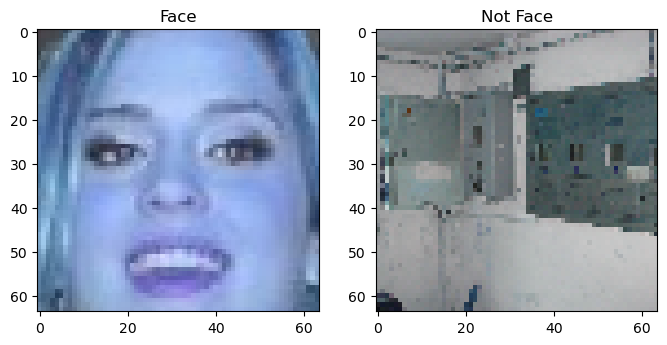

In [4]:
(images, labels) = loader.get_batch(100)
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 19 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 8 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)
     

## CNN for facial Detection
Here, we will define and train a CNN model to classify whether a given image is a face or not. We will then evaluate its accuracy

### Define the CNN 
The CNN model has a standard acchitecture consisting of a series of convolution layers with batch normalization followed by fully connected layers (two in our case) to flatten the output and generate a loss prediction

In [5]:
n_filters = 12 # The base number for convolutional filters

def make_standard_classifier(n_outputs=1): # One output in the final layer
    # Creating partial functions to help in defining the CNN layers
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    
    # Creating an instance of the sequential model
    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),
        
        Flatten(),
        Dense(512),
        Dense(n_outputs, activation=None)
    ])
    return model
    
standard_classifier = make_standard_classifier()



2023-05-31 06:36:56.107660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/arnold/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-31 06:36:56.107777: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-31 06:36:56.107819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linus): /proc/driver/nvidia/version does not exist
2023-05-31 06:36:56.108260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

### Train the CNN
We will train it using the tf.GradientTape class and the tf.GradientTape.gradient method

KeyboardInterrupt: 

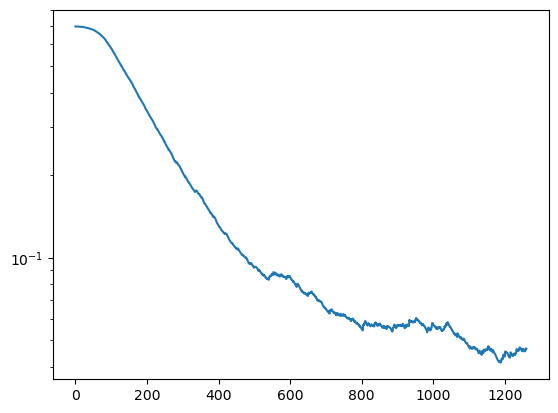

In [5]:
# Setting the training hyperparams
batch_size = 32 # Samples to be processed per iteration
num_epochs = 4 #  Number of times the entire dataset will be passed through the model during training
learning_rate = 0.00004 # The step size at each iteration during optimization process
train_size = len(loader.pos_train_inds) + len(loader.neg_train_inds)

optimizer = tf.keras.optimizers.Adam(learning_rate) # The optimizer usd to train the model
loss_history = LossHistory(smoothing_factor=0.99) # To record the loss values
plotter = PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): 
    tqdm._instances.clear() # Clears an instance of the progress bar if they exist

@tf.function
def standard_train_step(x, y): # Training step
    with tf.GradientTape() as tape:
        # Feed the images into the model
        logits = standard_classifier(x)
        # Compute the loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) # Applies a sigmoid activation function and compues the cross-entropy loss between the true labels and the precicted logits
     # Back propagation
    grads = tape.gradient(loss, standard_classifier.trainable_variables) # Calculates the gradient loss wrt the trainable variables of the standard classifier model
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables)) # Use the computed gradients with the optimizer defined above to update the trainable variables
    return loss

# The training loss
for epoch in range(num_epochs):
    for idx in range(train_size//batch_size): # This ensures that the entire training dataset is processed in batches.
        x, y = loader.get_batch(batch_size) # Retrieving a batch of training data. x and y store image and corresponding labels respectively
        loss = standard_train_step(x, y) # Call the training function defined above to perform the training
        loss_history.append(loss.numpy().mean()) # add the loss values to the loss objects
        plotter.plot(loss_history.get()) # Plotting the evolution of the loss 
    


### Evaluate the Performance of the CNN

In [6]:
(batch_x, batch_y) = loader.get_batch(5000) # Unpacking our evaluation batch into images (x) and labels (y)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x))) # Predicts the output of batch x and rounds off to the nerest 0 and 1 since it is a classifier problem
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32)) # Calculates the accuracy by comparing the predicted value with the true labels

print(f"Standard CNN accuracy on (potentially biased) training set : {acc_standard.numpy()}")

2023-05-31 06:36:56.604262: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


157/157 [==============================] - 2s 13ms/step
Standard CNN accuracy on (potentially biased) training set : 0.4675999879837036


## Variational autoencoder (VAE) 
Our goal is to train a model that learns a representation of the underlying latent space to the face training data. Such a learned representation will provide information on what features are under-represented or over-represented in the data. If certain features, such as dark skin or hats, are rare in CelebA, the model may end up biased against these as a result of training with a biased dataset

We will first define the VAE loss function. x is the input image, x_recon is the reconstructed output image, mu is the encoded means of the latent space and kl_weight is the weight of the latent loss. 

In [7]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    latent_loss = 0.5*tf.reduce_sum(tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)) # The latent loss corresponds to the regularization term in the VAE loss function
    latent_loss = tf.reduce_mean(latent_loss) # Calculates the mean of the latent loss accross all the samples in the batch
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3)) # Defining the reconstruction loss as the absolute pixel-wise difference between the input and reconstruction
    vae_loss = reconstruction_loss + latent_loss * kl_weight # Computing the overall VAE loss using the reconstruction and latent loss
    
    return vae_loss
    

In a VAE, instead of directly sampling values for each latent variable, we use a reparameterization trick to make the sampling process differentiable and trainable. In simple terms, the reparameterization trick in VAEs involves generating latent variables by combining a mean vector and a standard deviation vector, using a noise value sampled from a standard Gaussian distribution. This trick enables efficient training, random sampling, and improved network generalization.



In [8]:
def sampling(z_mean, z_logsigma): # z_mean is the mean and z_logsigma is the standard deviation of the latent distribution
    batch, latent_dim = z_mean.shape # Extracting the dimensions of the mean of the latent distribition
    epsilon = tf.random.normal(shape=(batch, latent_dim)) # Generating a tensor of random variables (epsilon) witht the shape matching the one of the mean of the latent distribution
    z = z_mean + tf.math.exp(0.5*z_logsigma) * epsilon # Defining the reparameterizatio computation
    
    return z

### Semi-supervised VAE
We will build a SS-VAE and apply it to our classification problem -- the facial detection project. We only need to learn the latent representation of the faces. Therefore, we need to make sure that for the faces, our SS-VAE model learns the representation of the unsupervised latent variables as well as the output of the supervised class predictions. However, for the negative examples (non faces), it should only output a class prediction. 

#### Defining the loss function
For the positive samples, our loss will contain both the VAE loss and the Classification Loss. For the negative samples, it will only contain the classification loss. For the function below, x is the true input images, x_pred is the reconstructed image, y is the true label, y_logit is the predicted labels, mu is the mean of the latent distribution and the logsigma is the standard deviation of the latent distribution

In [9]:
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # Calling the function defined earlier to compute the loss function
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit) # Computing the classification loss using the sigmoid_cross_entropy
    face_indicator = tf.cast(tf.equal(y,1), tf.float32) # Creating a binary indicator for detecting whether images are faces or not
    total_loss = tf.reduce_mean(classification_loss + face_indicator * vae_loss) # Calculating the total loss for the SS-VAE through combining the classification and vae losses
    
    return total_loss, classification_loss, vae_loss

#### Defining the SS-VAE architecture
To do this, we will use the standard CNN as our encoder and then define a decoder network then constuct an end-to-end VAE. But for the decoder layer, we will use deconvolution layers (conv2DTranspose) to upsample the latent variables. 

In [10]:
### Defining the decoder portion of the SS-VAE ###

def decoder_network(n_filters=12):
    # Defining the layers that will be used 
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='sigmoid')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape
    
    # Building the decoder network
    decoder = tf.keras.Sequential([
        # Transforming to pre-convolution generation
        Dense(units=4*4*6*n_filters), # Increase the dimensionality of the input latent variables
        Reshape(target_shape=(4, 4, 6*n_filters)), # Reshaping the feature maps from the previous layer
        
        # Upscaling the convolution layers to generate a reconstruction with the same spatial dimensions as the original image
        Conv2DTranspose(filters=4*n_filters, kernel_size=3, strides=2),
        Conv2DTranspose(filters=2*n_filters, kernel_size=3, strides=2),
        Conv2DTranspose(filters=1*n_filters, kernel_size=3, strides=2),
        Conv2DTranspose(filters=3, kernel_size=3, strides=2),
    ])
    
    return decoder

Now that we have our decoder, we will put it together with the standard CNN classifier (encoder) to define an end-to-end SS-VAE

In [11]:
class SS_VAE (tf.keras.Model): # Subclassing the Model to create a SS-VAE model
    # Initialize the class
    def __init__(self, latent_dim): 
        super(SS_VAE, self). __init__()
        self.latent_dim = latent_dim        
        num_encoder_dims = 2*self.latent_dim + 1 # Calculates the number of outputs based on the latent dimensions
        self.encoder = make_standard_classifier(num_encoder_dims) # Creating the encoder network using the standard CNN classifier defined above
        self.decoder = decoder_network() # Creating the decoder network using the decoder poerion of the SS-VAE defined above. 
    
    # Feeding images into the encoder
    def encode(self, x):
        encoder_output = self.encoder(x) # Passes the input to the encoder network
        y_logit = tf.expand_dims(encoder_output[:,0],-1) # Grabbing the first column of the encoder_output and adding a new dimension to it. 
        z_mean = encoder_output[:,1:self.latent_dim+1] # Obaining the latent mean
        z_logsigma = encoder_output[:,self.latent_dim+1:] # Obtaining the latent standard deviation
        
        return y_logit, z_logsigma, z_mean
    
    # Decoding the Latent space and output reconstruction
    def decode(self, z):
        reconstruction = self.decoder(z) # Taking the latent variable (z), use the decoder network to process it and generate reconstuction
        
        return reconstruction
    
    # Passing the inputs x through the core VAE
    def call(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x) # Calling the encode function to obtain the classification predictions and parameters of the latent space
        z = sampling(z_mean, z_logsigma) # Calling the sampling function to obtain a sample from the latent space
        recon = self.decode(z) # Calling the decode function to generate reconstruction of the input data from the latent space
        
        return y_logit, z_mean, z_logsigma, recon
    
    # Predicting a face or not dace logit for a given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit
    
ss_vae = SS_VAE(latent_dim=32) # Initialize the SS-VAE model with a latent space of 32 latent variables and


#### Training the SS-VAE
With the whole architecture defined, we will not train our model

Starting epoch 1/6


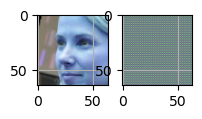

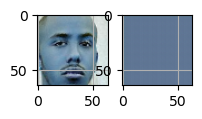

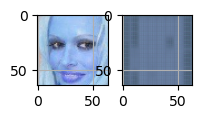

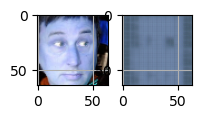

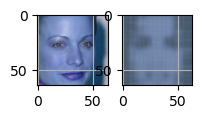

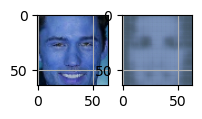

Starting epoch 2/6


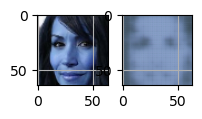

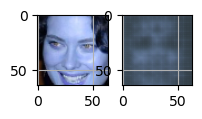

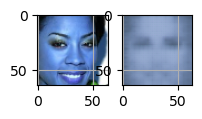

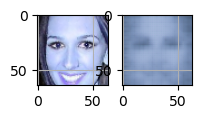

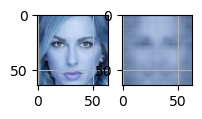

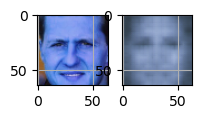

Starting epoch 3/6


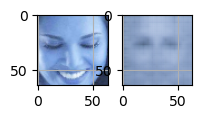

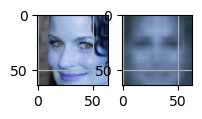

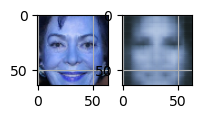

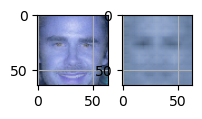

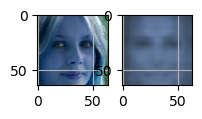

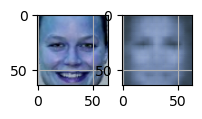

Starting epoch 4/6


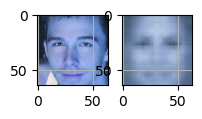

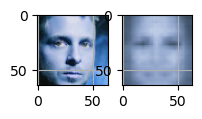

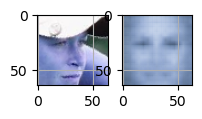

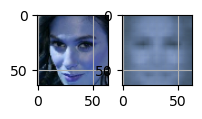

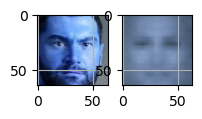

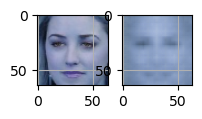

Starting epoch 5/6


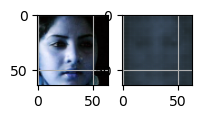

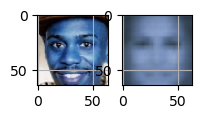

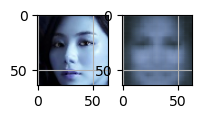

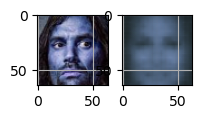

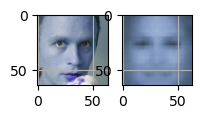

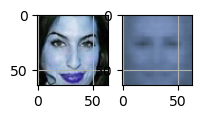

Starting epoch 6/6


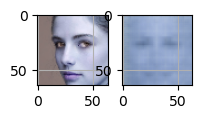

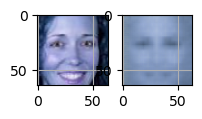

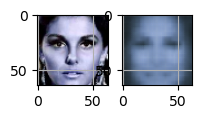

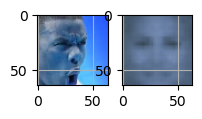

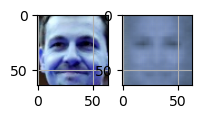

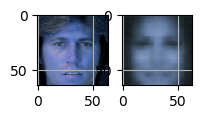

In [12]:
# Hyper-parameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32
num_epochs = 6 # SS-VAE needs more empchs to train since it is a more complex network than the standard classifier

# Instantiating the model and our Adam optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Defining our training operation
@tf.function
def ss_vae_train_step(x, y):
    with tf.GradientTape() as tape: 
        y_logit, z_mean, z_logsigma, x_recon = ss_vae(x) # Feeding the input x into our SS-VAE model adn expecting the classification prediction, latent mean, latent standard deviation and the output reconstructon
        loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # Calculating the loss using the loss function created above
    grads = tape.gradient(loss, ss_vae.trainable_variables) # computing the gradients wrt to the trainable variables of the SS_VAE
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables)) # Apply the gradient to the variables
    
    return loss

# Get training faces from the dataloader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, "_intances"): tqdm._instances.clear() # Clear if exists

# Training Loop
for i in range(num_epochs): # Iterates over the number of epochs
    print(f"Starting epoch {i+1}/{num_epochs}")
    for j in range(loader.get_train_size() // batch_size): # Iterates over the number of training steps per epoch
        (x, y) = loader.get_batch(batch_size) # Loading a batch of data
        loss = ss_vae_train_step(x, y) # Optimizing the loss
        
        # Plotting the progress
        if j % 500 == 0:
            utils.plot_sample(x, y, ss_vae)          
        
    

        

## Using SS-VAE to uncover and diagnose biases
the main goal of training our SS-VAE was to learn the underlying *latent distribution* of features and eventually uncover the potential feature representation disparities within the data. Our reconstruction loss is a reflection of how well the model is able to handle input data. Through this, we can tell which features seemed harder to learn, i.e the ones with the highest reconstruction loss. What might it tell us about the struggles of the model and what predictions it may be inbiased or uncertain about?

### Linking the Model performance to uncertainity and bias

In [14]:
# Loading a random sample of 5000 faces from our dataset and compute the model performance on then
(x, y) = loader.get_batch(5000, only_faces=True)


TypeError: get_batch() got an unexpected keyword argument 'only_faces'